In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from matplotlib.transforms import Affine2D
import numpy as np
import math
from matplotlib.patheffects import RendererBase
import matplotlib.patheffects as PathEffects
import seaborn as sns

In [398]:
def Rotate(v, theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]]) @ np.array(v).T

def AreCirclesOverlap(x1, y1, raidus1, x2, y2, radius2, gap = 0):
    if ((x1-x2)**2 + (y1-y2)**2 < (radisu1 + raidus2 + gap)**2):
        return True
    return False

def DrawPolygon(x, y, radius, n_edge, facecolor, ax):
    """
    Draw a shape with n_edges centered at x,y, with raidus (center to corner)
    n_edge <= 0 means circle
    """
    if (n_edge > 0):
        points = []
        for j in range(n_edge):
            cx = 0
            cy = radius
            cx, cy = Rotate([cx, cy], (j-0.5) * 2*math.pi/n_edge)
            points.append([cx+x, cy+y])
        ax.add_patch(patches.Polygon(points, facecolor=color, edgecolor="white"))
    else:
        ax.add_patch(patches.Circle([x,y], radius=radius, facecolor=facecolor,
                                   edgecolor="white"))
    return ax

def GetLapGap(radius, n_edge):
    """
    The gap between two laps for the same-cluster plotting
    """
    return max([11 / 5 * radius / math.cos(math.pi / n_edge),#  extra 20% in the radius for buffer
                      6 / 5 * radius / math.sin(math.pi / n_edge)] # gap should be large enough so dots in the same lap does not overlap
              )

def EstimateClusterRectangularRegion(center_x, center_y, data, n_edge, radius):
    """
    Estimate the rectangular region 
    
    Return:
    -----
    (x_min, y_min), (x_max, y_max)
    """
    count = len(data)
    lap_gap = GetLapGap(raidus, n_edge)
    n_lap = math.ceil(math.sqrt(n_edge**2 + 8*(count-1)*n_edge)/(2*n_edge) - 0.5 )
    return (center_x - lap_gap * n_lap - radius, \
            center_y - lap_gap * n_lap - radius), \
         (center_x +lap_gap * n_lap + radius, \
            center_y + lap_gap * n_lap + radius)

def EstimateClusterCircularRegion(center_x, center_y, data, n_edge, radius):
    """
    Esimate the circular region
    
    Return:
    -----
    center_x, center_y, radius
    """
    count = len(data)
    if (count == 1):
        return center_x, center_y, radius
    lap_gap = GetLapGap(radius, n_edge)
    n_lap = math.ceil(math.sqrt(n_edge**2 + 8*(count-1)*n_edge)/(2*n_edge) - 0.5 )
    return center_x, center_y, n_lap * lap_gap + radius

def CirclePushOut(x, y, r, x1, y1, r1, gap):
    """
    Push x, y, r away from x1,y1,r1 to make sure they have a gap at least gap
    
    Return:
    -----
    new center x,y
    """
    if (AreCircleOverlap(x, y, r, x1, y1, r1, gap) == False):
        return x, y
    
    d = math.sqrt((x-x1)**2 + (y-y1)**2)
    norm = math.sqrt(x**2 + y**2)
    norm1 = math.sqrt(x1**2 + y1**2)
    
    # normalized vector for (x,y)
    nx, ny = x/norm, y/norm 
    
    # project (x1,y1) to v-(x,y)
    costheta = (nx * x1 + ny *y1) / norm1
    px, py = nx * norm1 * costheta, ny * norm1 * costheta
    
    projectd = math.sqrt((px - x1)**2 + (py - y1)**2)
    # push away this distance. r+r1+gap is the ideal center distance
    pushd = math.sqrt((r + r1 + gap) ** 2 - projectd**2)
    
    return nx * (pushd + norm1 * costheta), ny * (pushd + norm1 * costheta)

# Draw one cluster
def DrawCluster(center_x, center_y, data, hue, hue_map, facecolor, n_edge, radius, layout, ax):
    """
    Draw the plot for one cluster represent by data
    
    Return:
    -----
    axes object
    radius of the cluster circular region
    """
    
    count = len(data)
    x = []
    y = []
    
    colors = []
    if (hue != None):
        hue_counts = []
        for h, cnt in data[hue].value_counts().items():
            c = facecolor
            if (h in hue_map):
                c = hue_map[h]
            for i in range(cnt):
                colors.append(c)
    else:
        colors = [facecolor for i in range(count)]
    
    region_radius = 0
    if (layout == "lap"):
        lap = 0
        
        #center difference between two laps
        lap_gap = GetLapGap(radius, n_edge)
               
        i = 0 
        while (i < count):
            tmpx = 0
            tmpy = lap * lap_gap 
            if (i == 0):
                tmpx, tmpy = Rotate([tmpx, tmpy], i * 2*math.pi/n_edge)
                x.append(tmpx + center_x)
                y.append(tmpy + center_y)
                i += 1
            else:
                k = 0
                for j in range(i, min(i+lap*n_edge, count), lap):
                    tmpx1, tmpy1 = Rotate([tmpx, tmpy], k * 2*math.pi/n_edge)
                    tmpx2, tmpy2 = Rotate([tmpx, tmpy], (k+1) * 2*math.pi/n_edge)
                    for l in range(j, min(j + lap, count)):
                        coef = (j + lap - l) / lap
                        x.append(coef*tmpx1 + (1-coef)*tmpx2 + center_x)
                        y.append(coef*tmpy1 + (1-coef)*tmpy2 + center_y)
                    k += 1
                i += lap * n_edge
            lap += 1
        region_radius = lap * lap_gap + radius
    elif (layout == "layer"):
        return ax
    elif (layout == "spiral"):
        return ax
    #print(x, y)
    for i, (xi, yi) in enumerate(zip(x, y)):
        DrawPolygon(xi, yi, radius, 0, colors[i], ax)
    return ax, region_radius

def HoneycombPlot(data, group, hue = None, facecolor = 'blue', 
                  layout="lap", n_edge=6, radius=1, group_firstlap_n = 6, 
                  palette=None, ax=None):
        """
        Draw the honeycomb plot 
        
        Args:
        -----
        data: panda dataframe holding the row data
        group: the column name in data that 
        hue: color of the dot based on the column in the dataframe. Use default color if it is not specified in this dictionary
        facecolor: color of the dot if hue is not specified.
        n_edge: number of edge for each cluster's shape, default 6 is a like heagonal shape
        radius: dot size
        group_firstlap_n: how many groups to put in the first lap (default: 6)
        layout: how to draw the dot within one cluster. 
                "spiral": a shape of spiral. 
                "lap": a dot in the center, and other dots around it as laps.
                "layer": dots a placed layer by layer 
        ax: axes objective
        
        Return:
        -----
        axes object
        """
        
        ax = ax or plt.gca()
        
        groupby = data.groupby(group)
        cluster_num = len(groupby)
        
        hue_map = {}
        if (hue != None):
            hlist = list(data[hue].unique())
            mypalette = sns.color_palette("bright", len(hlist))
            for i, h in enumerate(hlist):
                hue_map[h] = mypalette[i]
                
        #if (hue != None):
        #    hue_categories = 
        i = 0 
        j = 0 # track within lap coordinate
        lap = 0
        lap_start = 0 
        lap_full = 1
        group_gap = 4 * radius
        cluster_regions = [[]] # a list of list, the first list is for each cyle, 
                            #and a second layer  element is a triple, centerx,y and raidus 
                            # The values here is before global shifting
        
        inner_angle = 2 * math.pi / group_firstlap_n # the turning angle for first lap
        shift_x = 0 # shift everything
        shift_y = 0
        for g, subdf in sorted(data.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
            # find the appropriate positions
            center_x = 0
            center_y = 0 
            x, y, r = EstimateClusterCircularRegion(0, 0, subdf, n_edge, radius)
            if (lap > 0):
                if (lap == 1):
                    px, py, pr = cluster_regions[lap - 1][0]
                    center_x, center_y = Rotate([0, pr + group_gap + r], inner_angle * (i - lap_start))                    
                elif (lap > 1):
                    # The position of this group is determined by two in the inner layer and the previous one
                    k = math.floor((i - lap_start) / 2) # the index in the previous lap

                    if ((i - lap_start)%2 == 0) : # directly pushed a way from previous-lap group
                        px, py, pr = cluster_regions[lap - 1][k]
                        gap = group_gap_ratio * max(pr, r)
                        pl = math.sqrt(px**2 + py**2)
                        l = px * pl                    

                    else: # between two groups from previous lap
                        k += 1
                        if (k >= (lap - 1) * grow_factor):
                            k = 0
               
                # The previous group on the same lap
                if (i > lap_start):
                    px, py, pr = cluster_regions[lap][-1]
                    center_x, center_y = CirclePushOut(center_x ,center_y, r,
                                                      px, py, pr)
                        
                # Then also need to consider the 
                if (i == lap_full):
                    a = 0
                    
            ax, cluster_radius = DrawCluster(center_x + shift_x, center_y + shift_x, subdf, hue, hue_map, facecolor, n_edge, radius, layout, ax)
            cluster_regions[lap].append([center_x, center_y, cluster_radius])
            i += 1
            j += 1
            if (i == lap_full):
                cluster_regions[lap].append( cluster_regions[lap][0] )
                cluster_regions.append([])
                lap += 1
                j = 0
                lap_start = i
                lap_full += lap * group_firstlap_n
        return ax
        

IndentationError: expected an indented block after 'if' statement on line 240 (3861140863.py, line 243)

In [384]:
df = pd.DataFrame({"CDR3":["ABC", "ABC", "ABC", "ABC",
                          "ABC", "ABC", "ABC", "ABC",
                          "ABC", "DEF", "DEF", "GHI",
                          "JKL", "JKL", "JKL",
                          "MNO", "MNO", "MNO", "MNO"],
                  "Condition":["HD", "HD", "HD", "HD",
                              "D", "D", "HD", "D",
                              "HD", "HD", "D", "D",
                              "HD", "HD", "D",
                              "D", "D", "D", "HD"]})

[(-20.0, 20.0), (-20.0, 20.0)]

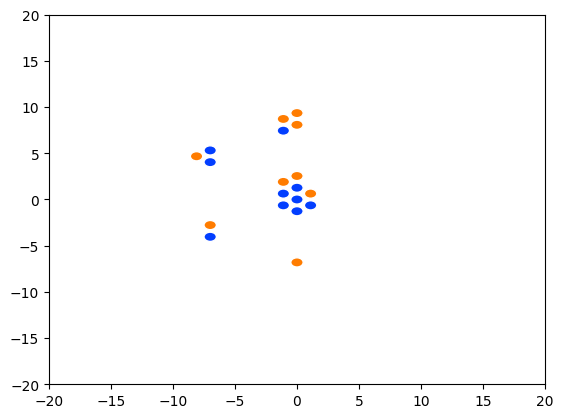

In [396]:
ax=HoneycombPlot(df, "CDR3", hue="Condition", n_edge=6, radius=0.5)
ax.set(xlim=(-20, 20), ylim=(-20,20))

In [231]:
df[df["CDR3"]=="ABC"]

,CDR3,Condition
0,ABC,HD
1,ABC,HD
2,ABC,HD
3,ABC,HD
4,ABC,D
5,ABC,D
6,ABC,HD
7,ABC,D
8,ABC,HD


In [170]:
for x, subdf in sorted(df.groupby("CDR3"), key=lambda item: len(item[1]), reverse=True):
    print(x)
    print(subdf)

ABC
  CDR3 Condition
0  ABC        HD
1  ABC        HD
2  ABC        HD
3  ABC        HD
4  ABC         D
5  ABC         D
6  ABC        HD
7  ABC         D
8  ABC        HD
DEF
   CDR3 Condition
9   DEF        HD
10  DEF         D
GHI
   CDR3 Condition
11  GHI         D
